In [1]:
import sys
sys.path.append('model/ak12_Mask_RCNN') # directory you want to access that you might wanna put more accuratly

In [18]:
import mrcnn.utils
import mrcnn.config
import mrcnn.model


In [3]:
from xml.etree import ElementTree

In [4]:
data_path = './data/kangaroo/'
filename = '00001'
annot_filename = data_path + 'annots/' + filename + '.xml'
img_filename = data_path + 'images/' + filename + '.jpg'

In [5]:
with open(annot_filename) as f:
    print(f.read())

<annotation>
	<folder>Kangaroo</folder>
	<filename>00001.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/stock-photo-two-kids-in-the-zoo-feeding-kangaroo-296180786.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>450</width>
		<height>319</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>233</xmin>
			<ymin>89</ymin>
			<xmax>386</xmax>
			<ymax>262</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>105</ymin>
			<xmax>341</xmax>
			<ymax>253</ymax>
		</bndbox>
	</object>
</annotation>



In [6]:
xml_tree = ElementTree.parse(annot_filename)

In [7]:
annotation = xml_tree.getroot()
print('root: ', annotation)

root:  <Element 'annotation' at 0x0000024328FE5408>


In [8]:
from PIL import Image

image = Image.open(img_filename)

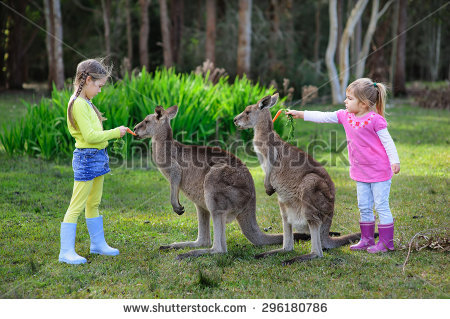

In [9]:
display(image)

In [10]:
boxes = []

def get_xml_int(xml_element, name):
    str_value = xml_element.findtext(name)

    if not str_value: 
        inner_values = {x.tag : x.text for x in xml_element}
        raise ValueError(
            f'Invalid value for type <int> when searching for <{name}> in <{xml_element.tag}> which contains: {inner_values}'
        )

    return int(str_value)

for box in annotation.iter('bndbox'):
    xmin = get_xml_int(box, 'xmin')
    ymin = get_xml_int(box, 'ymin')
    xmax = get_xml_int(box, 'xmax')
    ymax = get_xml_int(box, 'ymax')
    coordinates = [xmin, ymin, xmax, ymax]
    boxes.append(coordinates)
width = get_xml_int(annotation, './/size/width')
height = get_xml_int(annotation, './/size/height')


print(f'w: {width}, h:{height}')
print(f'bounding boxes: ', boxes)

w: 450, h:319
bounding boxes:  [[233, 89, 386, 262], [134, 105, 341, 253]]


### Draw bounding box

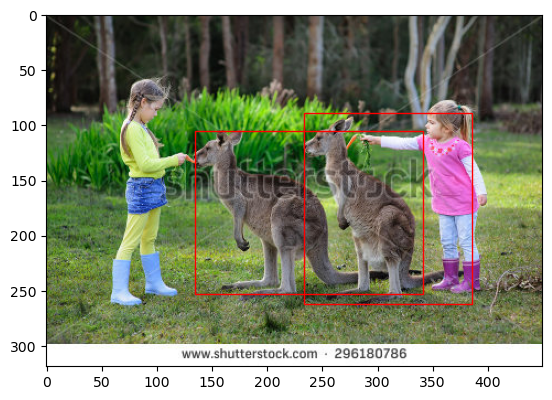

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy import asarray
plt.imshow(asarray(image))

ax = plt.gca()
for box in boxes:
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    
    rectangle = Rectangle((xmin, ymin), width, height, fill=False, color = 'red')
    ax.add_patch(rectangle)

plt.show()

## Make the dataset Object

In [12]:
from mrcnn.utils import Dataset
from os import listdir
from pprint import pprint

class KangarooDataset(Dataset):
    def __init__(self, debug = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug
        self.debug_limit = 2
        self.bad_images = ['00090']
        self.source = 'dataset'
        self.train_size = 150
        
    def load_data(self, dataset_dir, is_train=True):
        self.add_class(self.source, 1, 'kangaroo')

        images_dir = dataset_dir + 'images/'
        annotations_dir = dataset_dir + 'annots/'

        for filename in listdir(images_dir):
            # get image id
            image_id = filename[:-4] # skipping file extension '.jpg'
            
            if self.debug and int(image_id) > self.debug_limit: break

            # skip bad ones
            if image_id in self.bad_images: continue

            image_path = images_dir + filename 
            annotation_path = annotations_dir + image_id + '.xml'

            # training/validation 
            if is_train and int(image_id) >= self.train_size: continue
            if not is_train and int(image_id) < self.train_size: continue

            # add to ds
            self.add_image(self.source, image_id=image_id, path=image_path, annotation=annotation_path)
        
        if self.debug:
            print('-- Image info --')
            pprint(self.image_info)

    

In [13]:
import numpy as np
from PIL import Image,ImageDraw

def extract_boxes(self, annotation_path):
	xml_tree = ElementTree.parse(annotation_path)
	annotation = xml_tree.getroot()

	boxes = []
	for box in annotation.iter('bndbox'):
		xmin = get_xml_int(box, 'xmin')
		ymin = get_xml_int(box, 'ymin')
		xmax = get_xml_int(box, 'xmax')
		ymax = get_xml_int(box, 'ymax')
		coordinates = [xmin, ymin, xmax, ymax]
		boxes.append(coordinates)
	width = get_xml_int(annotation, './/size/width')
	height = get_xml_int(annotation, './/size/height')

	if self.debug: 
		print(f'width: {width}, height: {height}, boxes: ')
		pprint(boxes)
	return boxes, width, height
def load_mask(self,image_id): 
	info = self.image_info[image_id]
	annotation_path = info['annotation']

	boxes, w, h = self.extract_boxes(annotation_path)

	class_ids = []
	masks = np.zeros([h, w, len(boxes)], dtype=np.uint8)
	for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
		masks[ymin:ymax, xmin:xmax, i] = 1
		class_ids.append(self.class_names.index('kangaroo'))
	
	return masks > 0, np.asarray(class_ids, dtype=np.int32)

def image_reference(self, image_id):
	info = self.image_info[image_id]
	return info['path']

KangarooDataset.load_mask = load_mask
KangarooDataset.extract_boxes = extract_boxes
KangarooDataset.image_reference = image_reference

train_set = KangarooDataset()
train_set.load_data('./data/kangaroo/')
train_set.prepare()
print(f'train: ', len(train_set.image_ids))
val_set = KangarooDataset()
val_set.load_data('./data/kangaroo/', is_train=False)
val_set.prepare()
print(f'val: ', len(val_set.image_ids))


train:  131
val:  32


In [14]:
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)

(319, 450, 3)


In [15]:
mask, class_id = train_set.load_mask(image_id)
print(mask.shape)

(319, 450, 2)


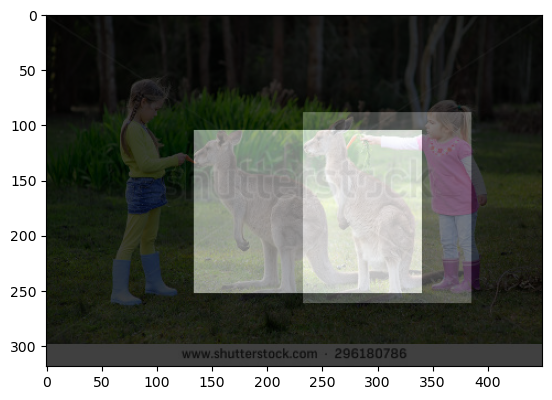

In [16]:
plt.imshow(image)
plt.imshow(mask[:,:,0], cmap='gray', alpha=0.5)
plt.imshow(mask[:,:,1], cmap='gray', alpha=0.5)
plt.show()

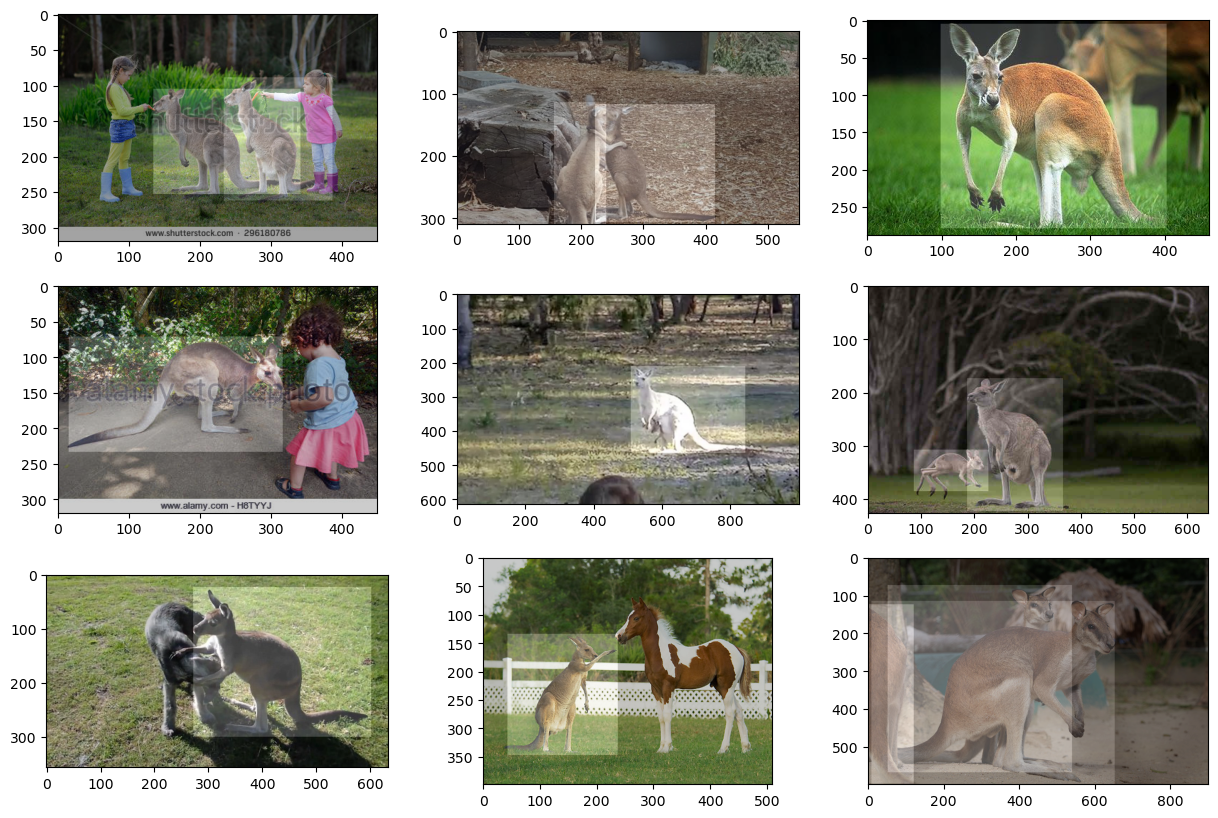

In [17]:
count = 9
nrow = 3
ncol =count // nrow
plt.figure(figsize=(15,10))
for i in range(count):
    plt.subplot(nrow, ncol, i+1)

    image = train_set.load_image(i)
    plt.imshow(image)
    masks, _ = train_set.load_mask(i)
    for mask_idx in range(masks.shape[2]):
        plt.imshow(masks[:,:, mask_idx], cmap='gray', alpha=0.2)

In [18]:
# To show all images info

# print('Images Info')
# pprint(train_set.image_info)

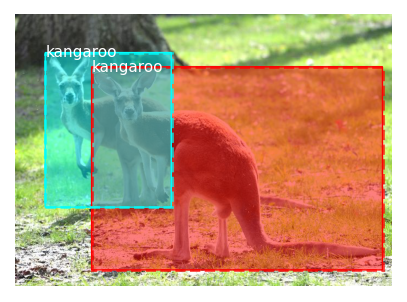

In [19]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
image_id = 25
image = train_set.load_image(image_id)
masks, class_ids = train_set.load_mask(image_id)
bounding_boxes = extract_bboxes(masks)

display_instances(image, bounding_boxes, masks, class_ids, train_set.class_names, figsize=(5,5))

## Training

In [20]:
from mrcnn.config import Config
'''
    I copy the doc-ed code from original implementation to understand what each config does
'''

#  TODO: update code and config for gpu training !!!
class KangarooConfig(Config):
    def get_config(self):
        return self.to_dict()

    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = 'kangaroo_cfg'  # Override in sub-classes

    
    # Number of classification classes (including background)
    NUM_CLASSES = 2  # Override in sub-classes

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 131

In [21]:
from scripts import verify_gpu

USE_GPU = verify_gpu.run()

TF Version:  2.1.0
------Devices------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13406989113856179900
,
 name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5061476352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5141502247337904377
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
--------------------------------
Num GPUs Available:  1
Has gpu:  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
if USE_GPU:
    print('Adding extra config for GPU-supported training')
    KangarooConfig.BACKBONE = 'resnet101'
    KangarooConfig.IMAGES_PER_GPU = 2
    KangarooConfig.GPU_COUNT = 1
    
config = KangarooConfig()
config.display()

Adding extra config for GPU-supported training

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_P

In [23]:
from mrcnn.model import MaskRCNN


model = MaskRCNN(mode='training', model_dir= './model/my_rcnn/', config= config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TODO: reinstall tf 2.0.0 gpu with anaconda and retry

In [24]:
model.load_weights('./model/mask_rcnn_coco.h5', by_name=True, 
    exclude=[
        'mrcnn_class_logits',
        'mrcnn_bbox_fc',
        'mrcnn_bbox',
        'mrcnn_mask'
    ]
)
# Can go here to see info about all weights/layers in the .h5 file
# https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_weights.ipynb

In [25]:
# model.keras_model.summary()

In [26]:
# layers: Allows selecting wich layers to train. It can be:
#     - A regular expression to match layer names to train
#     - One of these predefined values:
#       heads: The RPN, classifier and mask heads of the network
#       all: All the layers
#       3+: Train Resnet stage 3 and up
#       4+: Train Resnet stage 4 and up
#       5+: Train Resnet stage 5 and up

import time
EPOCHS = 5
start_train = time.time()

model.train(train_set, val_set, learning_rate = config.LEARNING_RATE, 
epochs=EPOCHS, layers = 'heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./model/my_rcnn/kangaroo_cfg20230103T2023\mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

f:\AppSSD\WorkTools\Anaconda\envs\kangaroo\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
f:\AppSSD\WorkTools\Anaconda\envs\kangaroo\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
f:\AppSSD\WorkTools\Anaconda\envs\kangaroo\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


131/131 [==============================] - 438s 3s/step - loss: 0.8116 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.2509 - val_loss: 0.7398 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.3146 - val_mrcnn_class_loss: 0.0236 - val_mrcnn_bbox_loss: 0.1677 - val_mrcnn_mask_loss: 0.2276
Epoch 2/5
131/131 [==============================] - 408s 3s/step - loss: 0.5368 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2022 - val_loss: 0.9197 - val_rpn_class_loss: 0.0145 - val_rpn_bbox_loss: 0.4538 - val_mrcnn_class_loss: 0.0402 - val_mrcnn_bbox_loss: 0.1704 - val_mrcnn_mask_loss: 0.2408
Epoch 3/5
131/131 [==============================] - 390s 3s/step - loss: 0.4328 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1879 - val_loss: 1.0308 - val_rpn_class_loss: 0.0148 -

In [27]:
model_final_path =  model.checkpoint_path.split('\\')[0].split('{')[0] + '/final_weights.h5'

In [28]:
model.keras_model.save_weights(model_final_path)

## Evaluation

In [29]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

In [30]:
# NOTE: https://github.com/matterport/Mask_RCNN/issues/960
class InferConfig(KangarooConfig):
    USE_MINI_MASK=False
    IMAGES_PER_GPU=1

infer_config = InferConfig()

In [31]:
infer_model = MaskRCNN(mode='inference', model_dir= './model/my_rcnn/', config= infer_config)
infer_model.load_weights(model_final_path, by_name=True)

In [32]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = np.expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose = 0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(
            gt_bbox, gt_class_id, gt_mask, 
            r['rois'], r['class_ids'], r['scores'], r['masks'])
        
        APs.append(AP)
    
    meanAP = np.mean(APs)
    return meanAP


In [33]:
start_train = time.time()

train_mAP = evaluate_model(train_set,infer_model, infer_config)
val_mAP = evaluate_model(val_set,infer_model, infer_config)

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Inference took {minutes} minutes')


print('Training mAP: ', train_mAP)
print('Validation mAP: ', val_mAP)

Inference took 2.4 minutes
Training mAP:  0.9087786265760281
Validation mAP:  0.953450521454215
